# Challenge supervised : toxicity on Youtube

<hr>

We decide to work with media content from Youtube platform. The given dataset contains information about the comments and the channels of a video. The objective of this analysis is to reflect on the toxicity of a video, but only through the comments of the video (and not really on the video content).

Our challenge notebook is composed of three main parts :
- <b>Exploratory analysis</b> : consists in a dataset description (using different graphs). We describe the different variables and what could be their use for the analysis of toxicity.
- <b>Regression with ML</b> : training a predictive model on the number of words considered as insults in the comments of around 40 000 Youtube videos.
- <b>Classification with hand made features and ML : </b>: creation and justification of a new variable called the toxicity index, and then train a classifier to predict this index on new video data.

Each regression and classification model will be assessed on a test set.

<hr>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import confusion_matrix, classification_report, f1_score

## Description

In [ ]:
#Dataset import and deletion of the last column according to doc

#If you use jupyter, uncomment the code below, otherwise let it commented

youtube =  pd.read_csv('challenge_youtube_toxic.csv', sep=';', decimal=',')
youtube = youtube.drop(youtube.columns[-1], axis=1)

#If you execute it on Colab, uncomment the line below
'''
youtube= pd.read_csv("challenge_youtube_toxic.csv", encoding="ISO-8859-1", sep=";")
'''

In [ ]:
youtube.head()

,video_id_court,video_id,channel_id,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new,categ_inst
0,Uvvsvw_wxOs,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLlV2dnN2d193eE9z,UC9GGzAhhvhJO1hL10-BcgNA,3813.0,18.0,4.0,145.0,79.0,60.0,"30,2619","0,1428571","0,03174603","1,150794","0,6269841","0,4761905",45.0,81.0,126.0,28.0,58.0,47.0,23.0,LeHuffPost,339922.0,225393312.0,Core,Pure Players
1,mCy1ZBdttwA,VVVYS0pyWWN6WTJfZkpFWmdGUEdZMEhRLm1DeTFaQmR0dHdB,UCXKJrYczY2_fJEZgFPGY0HQ,28.0,2.0,0.0,1.0,0.0,0.0,"9,333333","0,6666667",0,"0,3333333",0,0,3.0,0.0,3.0,0.0,3.0,1.0,0.0,CNEWS,189971.0,132125693.0,Core,TV
2,iU3MyHMK5nU,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLmlVM015SE1LNW5V,UC9GGzAhhvhJO1hL10-BcgNA,3804.0,68.0,9.0,56.0,75.0,54.0,"27,56522","0,4927536","0,06521739","0,4057971","0,5434783","0,3913043",52.0,86.0,138.0,22.0,83.0,49.0,36.0,LeHuffPost,339922.0,225393312.0,Core,Pure Players
3,ZUim3AeURtk,VVViWjBDc3I5b3c2WGprZGQ1NDJPbWh3LlpVaW0zQWVVUnRr,UCbZ0Csr9ow6Xjkdd542Omhw,4.0,0.0,1.0,2.0,0.0,0.0,2,0,"0,5",1,0,0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,Telegramme,2862.0,2481100.0,Niche,Presse_regionale
4,n5Tg2vhLCAM,VVVoWldzNlBKWTBoTkQzODRkMl9ScmhRLm41VGcydmhMQ0FN,UChZWs6PJY0hND384d2_RrhQ,737.0,3.0,1.0,18.0,5.0,6.0,"32,04347826","0,130434783","0,043478261","0,782608696","0,217391304","0,260869565",17.0,6.0,23.0,4.0,18.0,7.0,7.0,Les Echos,30010.0,6710737.0,Core,Presse nationale


<hr>

In [ ]:
nbVideoNoInsult = youtube[youtube['nbrMotInsulte'] == 0].count()[0]
print('Number of videos containing zero insults : {} '.format(nbVideoNoInsult))
print('Number of videos containing at least 1 insults : {} '.format(youtube.shape[0] - nbVideoNoInsult))

Number of videos containing zero insults : 18332 
Number of videos containing at least 1 insults : 14587 


- 44,3% of the dataset have at least a word considered as an insult in its comments.

In [ ]:
px.histogram(youtube[youtube['nbrMotInsulteMoyenne'] > 0], x='nbrMotInsulteMoyenne', title='Distribution of nbrMotInsulteMoyenne', nbins=50)

TypeError: ignored

In [ ]:
px.histogram(youtube[youtube['nbrMotInsulte']>0], x='nbrMotInsulte', title='Distribution of nbrMotInsulte', nbins=100)

In [ ]:
youtube[youtube['nbrMotInsulte'].isin([7227,3883,3352,2653])]

,video_id_court,video_id,channel_id,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new,categ_inst
14922,FFJBEPLe5Sg,VVVmSG5fOC1laGRlbTg2ZkV2bEZnLUd3LkZGSkJFUExlNVNn,UCfHn_8-ehdem86fEvlFg-Gw,662808.0,7227.0,1416.0,14270.0,11093.0,5520.0,"34,27844435","0,373758792","0,073231278","0,738001655","0,573696731","0,285477865",8141.0,11195.0,19336.0,1235.0,9837.0,3762.0,3732.0,Le Parisien,149018.0,85536183.0,Core,Presse_regionale
19166,ixVfsiIj9ww,VVVtYmhyS01VX1g3R2k0N2JaRUVhakVRLml4VmZzaUlqOXd3,UCmbhrKMU_X7Gi47bZEEajEQ,251261.0,3883.0,434.0,3928.0,2463.0,2007.0,"32,33732304","0,4997426","0,055855856","0,505534106","0,316988417","0,258301158",2794.0,4976.0,7770.0,396.0,4067.0,1551.0,1273.0,StreetPress,113042.0,24229865.0,Core,Pure Players
28430,ZD4l8W1g4vI,VVVmSG5fOC1laGRlbTg2ZkV2bEZnLUd3LlpENGw4VzFnNHZJ,UCfHn_8-ehdem86fEvlFg-Gw,222022.0,3352.0,517.0,2637.0,2786.0,2096.0,"35,0082","0,5285399","0,08152003","0,4157994","0,4392936","0,3304951",2660.0,3682.0,6342.0,453.0,3284.0,1206.0,1405.0,Le Parisien,149018.0,85536183.0,Core,Presse_regionale


- It looks like there is 1 outlier for Pure Players category and 3 outliers for Presse_regionale
- Those outliers have a nbrMotInsulteMoyenne between 29% and 34%
- The outliers for Presse_regionale category are all from the media Le Parisien
- Two of them are about policeman violence, we will keep those videos in our Dataset

In [ ]:
px.bar(youtube, x='channel_name')

In [ ]:
channels = pd.DataFrame(youtube, columns = ["channel_name","nbrMotInsulte","nbrMot"])
channels

,channel_name,nbrMotInsulte,nbrMot
0,LeHuffPost,18.0,3813.0
1,CNEWS,2.0,28.0
2,LeHuffPost,68.0,3804.0
3,Telegramme,0.0,4.0
4,Les Echos,3.0,737.0
...,...,...,...
32914,Le Figaro,0.0,24.0
32915,L'Express,0.0,1.0
32916,Le Monde,111.0,50735.0
32917,CNEWS,0.0,8.0


In [ ]:
channels['nbrMotInsulteMoyenne'] = channels['nbrMotInsulte']/channels['nbrMot']*100
channels

,channel_name,nbrMotInsulte,nbrMot,nbrMotInsulteMoyenne
0,LeHuffPost,18.0,3813.0,0.472069
1,CNEWS,2.0,28.0,7.142857
2,LeHuffPost,68.0,3804.0,1.787592
3,Telegramme,0.0,4.0,0.000000
4,Les Echos,3.0,737.0,0.407056
...,...,...,...,...
32914,Le Figaro,0.0,24.0,0.000000
32915,L'Express,0.0,1.0,0.000000
32916,Le Monde,111.0,50735.0,0.218784
32917,CNEWS,0.0,8.0,0.000000


In [ ]:
channels.sort_values(by='nbrMotInsulteMoyenne', ascending=False)

,channel_name,nbrMotInsulte,nbrMot,nbrMotInsulteMoyenne
13044,Les Echos,1.0,1.0,100.0
22896,Lequipe,2.0,2.0,100.0
5311,Dauphine_libere,1.0,1.0,100.0
25749,Ouest-France,1.0,1.0,100.0
6794,Ouest-France,1.0,1.0,100.0
...,...,...,...,...
18633,franceinfo,0.0,0.0,NaN
28474,Humanite,0.0,0.0,NaN
29906,LeHuffPost,0.0,0.0,NaN
31687,Ouest-France,0.0,0.0,NaN


After watching at the channel called ZDNet.FR on youtube, we observe that comments are disabled for watchers. Our analyse is based on comments. Thus, we decide to drop this channel and its videos from our dataset

In [ ]:
#px.scatter_matrix(youtube[['nbrMotInsulteMoyenne', 'nbrMotMoyenne','nbrMotMAJ','nbrExclMark']])

In [ ]:
#px.histogram(youtube[youtube['message_count']<200], x='message_count', nbins=50)

In [ ]:
youtube.sort_values(by='nbrMotInsulteMoyenne', ascending=False)[['video_id_court','nbrMot','nbrMotInsulte','comment_count','viewCount','subscriberCount', 'nbrMotInsulteMoyenne', 'message_count']][:50]

,video_id_court,nbrMot,nbrMotInsulte,comment_count,viewCount,subscriberCount,nbrMotInsulteMoyenne,message_count
28534,cH08z6V4UcY,128.0,9.0,0.0,132125693.0,189971.0,9,1.0
23718,eG3CHDHck0w,110.0,8.0,0.0,46356344.0,148033.0,8,1.0
27518,1bMU5T_VaRw,398.0,70.0,7.0,85536183.0,149018.0,7,10.0
5326,9JJ_628yBeM,155.0,14.0,0.0,132125693.0,189971.0,7,2.0
25085,bxUMGCeQRIo,225.0,7.0,0.0,132125693.0,189971.0,7,1.0
6720,tz0fVhI0rHk,64.0,7.0,0.0,132125693.0,189971.0,7,1.0
2700,vUEF2_EXL4Q,530.0,113.0,4.0,6710737.0,30010.0,"6,647058824",17.0
29256,a2i0EGhHr9I,419.0,13.0,0.0,132125693.0,189971.0,"6,5",2.0
5577,f31oe7yKZhY,110.0,13.0,0.0,132125693.0,189971.0,"6,5",2.0
23872,qEjK5q39UoE,324.0,12.0,0.0,132125693.0,189971.0,6,2.0


In [ ]:
#px.scatter_matrix(youtube[['nbrMotInsulte','nbrMotMAJ']])

In [ ]:
#px.scatter(youtube[youtube['nbrMotInsulte'] < 300],x='nbrMotInsulte', y= 'nbrMotMAJ')

In [ ]:
youtube[['nbrMotInsulte','nbrMotMAJ']].corr()

,nbrMotInsulte,nbrMotMAJ
nbrMotInsulte,1.000000,0.828247
nbrMotMAJ,0.828247,1.000000


In [ ]:
youtube.corr()

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount
nbrMot,1.000000,0.873429,0.859449,0.859074,0.818783,0.977200,0.802456,0.931067,0.915580,0.880455,0.837097,0.864928,0.863545,0.155838,0.070903
nbrMotInsulte,0.873429,1.000000,0.768796,0.828247,0.773864,0.856167,0.741647,0.866353,0.849509,0.769263,0.770751,0.794347,0.794985,0.078501,0.052868
nbrMotAllong,0.859449,0.768796,1.000000,0.782213,0.825718,0.864872,0.871233,0.872826,0.915813,0.848548,0.896284,0.815933,0.869909,0.147204,0.084149
nbrMotMAJ,0.859074,0.828247,0.782213,1.000000,0.850218,0.855539,0.773703,0.826091,0.842183,0.773494,0.781048,0.775570,0.788478,0.107236,0.049116
nbrExclMark,0.818783,0.773864,0.825718,0.850218,1.000000,0.842034,0.921084,0.795931,0.896324,0.783417,0.892768,0.772848,0.827254,0.102082,0.070168
nbrQuestMark,0.977200,0.856167,0.864872,0.855539,0.842034,1.000000,0.814256,0.928926,0.920070,0.892690,0.843394,0.874830,0.865260,0.159846,0.081503
thread_count,0.802456,0.741647,0.871233,0.773703,0.921084,0.814256,1.000000,0.812418,0.943813,0.823151,0.984410,0.803695,0.910214,0.122831,0.081567
comment_count,0.931067,0.866353,0.872826,0.826091,0.795931,0.928926,0.812418,1.000000,0.959466,0.944596,0.879167,0.903807,0.926031,0.181445,0.098868
message_count,0.915580,0.849509,0.915813,0.842183,0.896324,0.920070,0.943813,0.959466,1.000000,0.933251,0.974110,0.900729,0.964810,0.162211,0.095462
discussion_count,0.880455,0.769263,0.848548,0.773494,0.783417,0.892690,0.823151,0.944596,0.933251,1.000000,0.877168,0.918160,0.929995,0.217859,0.125122


__Remark__ = It looks like average variables, subscriberCount and viewCount don't correlate to nbrMotInsulte

In [ ]:
youtube[youtube['nbrMotInsulte'] == youtube['nbrMot']].sort_values(by='nbrMot', ascending=False)[['nbrMot', 'nbrMotInsulte','message_count']]

,nbrMot,nbrMotInsulte,message_count
2672,3.0,3.0,1.0
4159,3.0,3.0,1.0
5752,3.0,3.0,2.0
225,2.0,2.0,1.0
17956,2.0,2.0,2.0
24931,2.0,2.0,1.0
24279,2.0,2.0,1.0
22896,2.0,2.0,1.0
20504,2.0,2.0,1.0
15844,2.0,2.0,1.0


We drop this rows

In [ ]:
#px.histogram(youtube[youtube['nbrMot'] < 10000],x='nbrMot', nbins=200)

In [ ]:
#px.scatter(youtube[youtube['nbrMot'] != 0], x='nbrMot', y='viewCount')

<hr>

# Data preprocessing

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
#Check if values are missing 
#youtube.isna().sum()

In [ ]:
# Drop nbrMot equals to 0
youtube = youtube.drop(youtube[youtube['nbrMot']==0].index)
youtube = youtube.reset_index(drop=True)

# youtube variable is note used further, instead we use df 
target = youtube['nbrMotInsulte']
df = youtube.drop(['nbrMotInsulte', 'video_id', 'video_id_court', 'channel_id', 'nbrMotMoyenne', 'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne', 'nbrMotMAJMoyenne','nbrExclMarkMoyenne','nbrQuestMarkMoyenne'], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,target, test_size=0.2, random_state=5)

numerical = x_train._get_numeric_data()
categorical = list(set(x_train.columns)-set(numerical.columns))
print(categorical)

x_train = x_train.drop(categorical, axis=1)
x_test = x_test.drop(categorical, axis=1)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

['channel_name', 'categorie_new', 'categ_inst']
(26326, 14) (6582, 14) (26326,) (6582,)


In [ ]:
print('Number of videos containing zero insults : {} %'.format((y_test == 0).sum()/y_test.shape[0]*100))
print('Number of videos containing at least 1 insults : {} %'.format(((y_test.shape[0] - (y_test == 0).sum())/y_test.shape[0]*100)))

Number of videos containing zero insults : 55.94044363415376 %
Number of videos containing at least 1 insults : 44.05955636584625 %


In [ ]:
print('Number of videos containing zero insults : {} %'.format((y_train == 0).sum()/y_train.shape[0]*100))
print('Number of videos containing at least 1 insults : {} %'.format(((y_train.shape[0] - (y_train == 0).sum())/y_train.shape[0]*100)))

Number of videos containing zero insults : 55.6066246296437 %
Number of videos containing at least 1 insults : 44.3933753703563 %


In [ ]:
sc_x_train = StandardScaler()
sc_y_train = StandardScaler()
sc_x_test = StandardScaler()
sc_y_test = StandardScaler()

x_train_scaled = sc_x_train.fit_transform(x_train.values)
y_train_scaled = sc_y_train.fit_transform(y_train.values.reshape(-1,1))

x_test_scaled = sc_x_test.fit_transform(x_test.values)
y_test_scaled = sc_y_test.fit_transform(y_test.values.reshape(-1,1))

## SVR

In [ ]:
from sklearn import svm
from sklearn.metrics import r2_score

The code below enables us to perform a __grid search__ and to get the optimal set of hyperparameters for the SVM, which minimizes the training error. However, Support Vector Regression (and SVM in general) are known to scale badly with the number of individuals in the dataset. The hyperparameters considered are :
- The kernel transformation applied to the SVR input.
- The C coefficient for the margin of the SVM.
- Gamma coeffcient.

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

parameters = {'kernel':('linear', 'rbf'), 
              'C':[100,1000,10000],
                'gamma': [1,0.1,0.01,'auto','scale']}

svr = svm.SVR()

clf = GridSearchCV(estimator=svr, 
                   param_grid=parameters,
                   cv=5, verbose=2)

clf.fit(x_train_scaled, y_train_scaled)


print(clf.best_estimator_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV] END ......................C=100, gamma=1, kernel=linear; total time=15.4min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
clf = svm.SVR(kernel='linear', C=1e4, gamma=0.1)
clf.fit(x_train_scaled, y_train_scaled)

NameError: ignored

In [ ]:
clf.score(x_test_scaled, y_test_scaled)

<hr>

## KNN

In [ ]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.pipeline import Pipeline

We try many KNN with different value of k, then we commpare.

In [ ]:
score = []
#peut pas avoir 0 voisin donc commence à 1
for i in range(1,15):
    #Implémentation du model
    KNNmodel = KNeighborsClassifier(n_neighbors = i)
    
    #Training set
    KNNmodel.fit(x_train,y_train)
    score.append(KNNmodel.score(x_test, y_test))
    sc = KNNmodel.score(x_test, y_test, scoring = 'R2')
    print("Score for",i,"neighbors :", sc)

ValueError: ignored

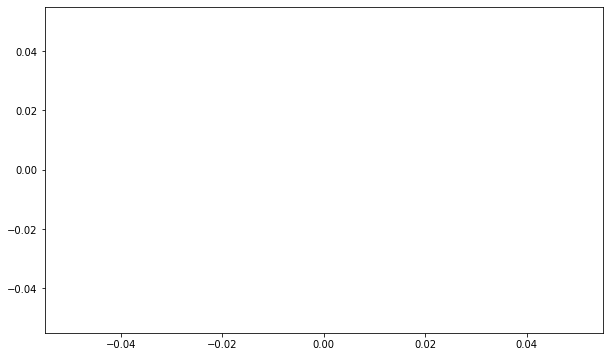

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(score)

The model is more effective with k = 8

##### Test with normalized data

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

mm = make_pipeline(Normalizer())
x_train_norm = mm.fit_transform(x_train)
x_test_norm = mm.transform(x_test)

ValueError: ignored

In [ ]:
KNNmodel = KNeighborsClassifier(n_neighbors = 8)

#Training set
KNNmodel.fit(x_train_norm,y_train)
KNNmodel.score(x_train_norm,y_train)

NameError: ignored

Test of our KNN

In [ ]:
#Testing set
test = KNNmodel.predict(x_test_norm)

In [ ]:
error = (y_test-test)**2
moindreCarre = np.mean(error)
print (moindreCarre)

1499.312357600087


We get better results with normalized data

# Logistic Regression

## Reduction of the number of features (only numerical features)

In [ ]:
DATA = youtube[['nbrMot', 'nbrMotAllong', 'nbrMotMAJ', 'nbrExclMark', 'nbrQuestMark', 'thread_count', 'comment_count', 'discussion_count', 'distinct_authors_count', 'authors_3channels_count', 'liked_authors_count', 'subscriberCount', 'viewCount', 'nbrMotInsulte']]
DATA

,nbrMot,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,thread_count,comment_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount,nbrMotInsulte
0,3813.0,4.0,145.0,79.0,60.0,45.0,81.0,28.0,58.0,47.0,23.0,339922.0,225393312.0,18.0
1,28.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0,189971.0,132125693.0,2.0
2,3804.0,9.0,56.0,75.0,54.0,52.0,86.0,22.0,83.0,49.0,36.0,339922.0,225393312.0,68.0
3,4.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2862.0,2481100.0,0.0
4,737.0,1.0,18.0,5.0,6.0,17.0,6.0,4.0,18.0,7.0,7.0,30010.0,6710737.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32903,24.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,180173.0,140135417.0,0.0
32904,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,68859.0,90646123.0,0.0
32905,50735.0,140.0,622.0,601.0,399.0,625.0,743.0,183.0,812.0,375.0,386.0,568615.0,134570352.0,111.0
32906,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,189971.0,132125693.0,0.0


Binning: we discretize the number of insult words. Each entry is associated with an insult word interval [nb1,nb2]. The boundaries of the intervals are the quantiles of the set composed of videos containing insult words (the 44% of the dataset)

In [ ]:
def binning(col):
    # Définir les valeurs min et max:
    minval = col.min()
    maxval = col.max()
    cut_points = []
    mask=col>1
    col2=col[mask]
    for i in range(9):
        cut_points.append(col2.quantile(q=i/10))
    # Créer une liste en ajoutant min et max à cut_points
    break_points = [minval] + cut_points + [maxval]
    break_points = list(set(break_points))
    break_points=sorted(break_points)
    print(break_points)
    # Si aucun label, on utilise par défaut les labels 0 ... (n-1)
    labels = range(len(break_points)-1)
    # Regroupement en utilisant la fonction cut de Pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin, break_points

We center and reduce so as not to favor one feature over another. We distinguish the explanatory variables from the target

In [ ]:
X=pd.DataFrame()
for k in DATA.columns:
    if k!='nbrMotInsulte':
        A = (DATA[k] - DATA[k].min()) / (DATA[k].max() - DATA[k].min())
        X[k] = (A - A.mean()) / A.std()

Y=DATA["nbrMotInsulte"]

We separe the dataset into a train and a test parts

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
Y_train, BP = binning(Y_train)

[0.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 26.0, 7227.0]


We train the model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils

modele_logit = LogisticRegression(solver='saga', multi_class='auto', max_iter=5000)
modele_logit.fit(X_train,Y_train)

ValueError: ignored

We associate to each output the value of the number of insult words according to its interval. Prediction is of type [0,1,2,3,4,5 ...], according to the number of the interval. We associate to each output a linear combination of the lower and upper limit of the interval.

In [ ]:
predictions = modele_logit.predict(X_test)
A=[]
for k in predictions:
    if k<len(BP)-1:
        A.append((BP[k]+0.015*BP[k+1])/1.1)
    else:
        A.append(BP[k])
predictions_nbInsultes = np.array(A)

AttributeError: ignored

In [ ]:
Diff=predictions_nbInsultes-Y_test
print("Moyenne des écarts :" , Diff.mean())
import plotly.express as px
fig = px.histogram(Diff, x="nbrMotInsulte")
fig.show()

NameError: ignored

In [ ]:
count=0
for k in Diff:
    if k>-2 and k<2:
        count+=1
print(count/len(Diff) , "% des prédictions sont bonnes à un mot près")

NameError: ignored

<hr>

## Regression Tree

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
rgr = tree.DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 2)
rgr = rgr.fit(x_train, y_train)

ValueError: ignored

In [ ]:
rgr.fit(x_train,y_train)
rgr.score(x_test,y_test) 

0.8164926765766691

We can see that a regression tree is not a bad solution because the accuracy is quite high with 81% however the result changes a lot with the train dataset  

In [ ]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(x_train.columns)

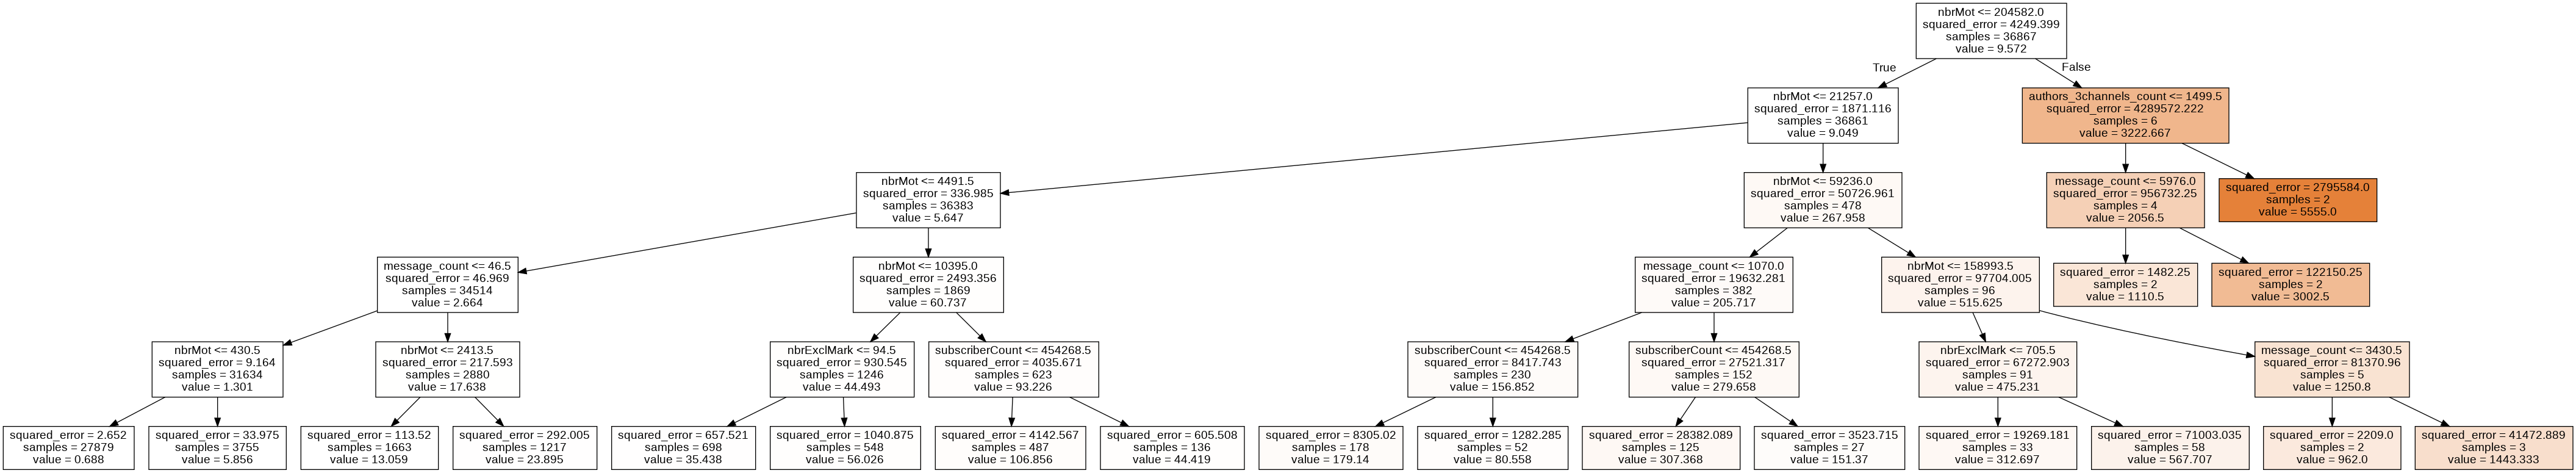

In [ ]:
dot_data = StringIO()
export_graphviz(rgr, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

With this tree we cas see what are the parameters that have an impact on the final results

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_rgr = RandomForestRegressor( n_estimators= 10, max_depth=5)
rf_rgr.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10)

In [ ]:
rf_rgr.fit(x_train,y_train)
rf_rgr.score(x_test,y_test)

0.7947416592756951

with a Random Forest Regressor we hav the same accuracy than with the regressor Tree However this time the accuracy is more stable and change less with the train dataset 

<hr>

## Multi Layer Perceptron

In [ ]:
import torch
import torch.nn as nn

In [ ]:
x_train_tensor = torch.Tensor(x_train_scaled.astype(np.float32))
y_train_tensor = torch.Tensor(y_train_scaled.astype(np.float32))

x_test_tensor = torch.Tensor(x_test_scaled.astype(np.float32))
y_test_tensor = torch.Tensor(y_test_scaled.astype(np.float32))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


We train a __multi-layer perceptron with relu activation__. Before that, we also tried a simple linear single layer network. It seems that the peformance are better with a more complex network.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        #self.fc1 = nn.Linear(14,1)
        self.fc1 = nn.Linear(14,20)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(20,20)
        self.drop2 = nn.Dropout(0.3)
        self.fc3=nn.Linear(20,1)
        self.rl1 = nn.ReLU()
        self.rl2 = nn.ReLU()

    def forward(self, x):
        #x= self.fc1(x)
        x = self.rl1(self.fc1(x))
        x = self.drop1(x)
        x = self.rl2(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x

net = MLP()

print(net)

MLP(
  (fc1): Linear(in_features=14, out_features=20, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (rl1): ReLU()
  (rl2): ReLU()
)


In [ ]:
from torch.optim import lr_scheduler

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
epochs = 5000 # number of epochs
losses = [] # list to stock the loss at each iteration

# Training mode
net.train()

# Loop on epochs
for i in range(epochs):
    # compute the prediction using the previous parameters of the neural network
    y_pred = net(x_train_tensor)
    # compute and stock the loss
    loss = criterion(y_pred, y_train_tensor)
    losses.append(loss)

    # initialize the gradient to zero
    optimizer.zero_grad()

    # compute the gradient by back propagation
    loss.backward()

    # update the parameter values using the gradient
    optimizer.step()
        
    #print(losses[-1])
    #exp_lr_scheduler.step()
    
print(losses[-1])

tensor(nan, grad_fn=<MseLossBackward0>)


Text(0.5, 1.0, 'Evolution of training set error with the number of epochs')

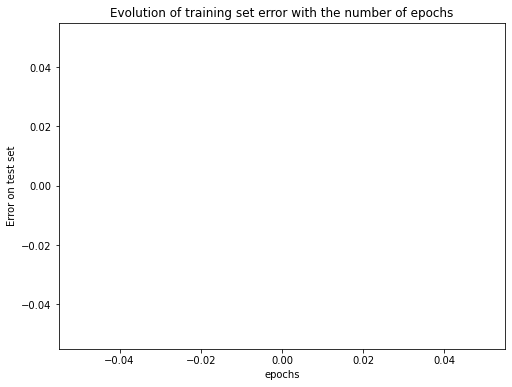

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('Error on test set')
plt.title('Evolution of training set error with the number of epochs')

In [ ]:
net.eval()

with torch.no_grad():
    outputs = net(x_test_tensor)

print("MSE :",criterion(outputs, y_test_tensor))
print("R2 score:", r2_score(outputs.numpy(),y_test_scaled))

MSE : tensor(nan)


NameError: ignored

# Gradient boosting

XGBoost is a popular gradient boosting algorithm. Our analysis only concerns XGBoost and not other gradient boosting algorithms.

In [ ]:
import xgboost as xgb

In [ ]:
boost = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, max_depth=5)

#boost.get_params()

boost.fit(x_train_scaled, y_train_scaled)

preds = boost.predict(x_test_scaled)

In [ ]:
from sklearn.metrics import mean_squared_error

scr = mean_squared_error(y_test_scaled, preds)

print(scr)

In [ ]:
print(r2_score(y_test_scaled, preds))

In [ ]:
xgb.plot_importance(boost)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()
print(numerical.columns)

As for the SVM, it can be interesting to perform a grid search to get the ideal set of hyperparameters. This task can be very long and depends on the computing ressources available for it.

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

xgb1 = xgb.XGBRegressor()

parameters = {'objective':['reg:squarederror'],
              'max_depth': [5, 6, 7, 8, 9],
              'colsample_bytree': [0.3, 0.4, 0.5],
              'n_estimators': [100]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 4,
                        n_jobs = 3,
                        verbose=True)

xgb_grid.fit(x_train_scaled,
         y_train_scaled)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

We could not test every combination of parameters. The best one is the following found so far.

In [ ]:
xg_best = xgb.XGBRegressor(objective='reg:squarederror', max_depth=5,n_estimators=100, colsample_bytree=0.3)
xg_best.fit(x_train_scaled, y_train_scaled)
preds = xg_best.predict(x_test_scaled)
print('MSE on test set:', mean_squared_error(y_test_scaled, preds))
print('R2 on test set:', r2_score(y_test_scaled, preds))

# Comparison of the different regression methods

In [ ]:
#SVR
print(clf.best_estimator_)

#KNN
print(KNNmodel.score(x_train_norm,y_train))

#Logistic Regression 
print(count/len(Diff))

#Random Forest Regressor (Regression Tree)
print(rf_rgr.score(x_test,y_test))

#Multi Layer Perceptron
print(losses[-1])

#Gradient Boosting
print(xgb_grid.best_score_)

#plot comparison
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
methods = ['SVR', 'KNN', 'Random Tree', 'MLP', 'Gradient Boosting']
results = [clf.best_estimator_, KNNmodel.score(x_train_norm,y_train), count/len(Diff), rf_rgr.score(x_test,y_test), losses[-1], xgb_grid.best_score_]
ax.bar(methods, results)
plt.show()

<hr>

# Toxicity score

In this part, we propose a new hand-made feature which we believe characterized the toxicity of a video. We tried two different approaches in order to build this feature. Both are based on taking a linear combination of variables:
- the first ones performs a PCA and assume the weights to be the eigenvalues of the decomposition.
- the other one uses the correlation matrix and its factor as the weights.

For each methods, we train a classifier and evaluate its generalization error. 

## PCA

Using a training set, we will determine the weights of the linear combination using a PCA on a train set. We firstly split the dataset into test and training sets. In a final step, these sets will be used to train a classifier.

In [ ]:
df_reduc = youtube.drop(['channel_name', 'categorie_new', 'categ_inst']+['video_id', 'video_id_court', 'channel_id', 'nbrMotMoyenne', 'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne', 'nbrMotMAJMoyenne','nbrExclMarkMoyenne','nbrQuestMarkMoyenne'], axis=1)
df_pca = df_reduc.drop('nbrMotInsulte', axis=1)

ratio = 0.8

indices = list(np.arange(0,df_reduc.shape[0]))
np.random.shuffle(indices)
split = int(df_reduc.shape[0]*0.8)

x_train = df_reduc.iloc[indices[:split],:]
print(x_train.shape)
x_test = df_reduc.iloc[indices[split:],:]

(36867, 15)


After centering and reducing the values of the training set, we perform the PCA and decide how many principal components will be enough for describing the variance of the set.

In [ ]:
from sklearn.decomposition import PCA

X = x_train.values
std = StandardScaler().fit(X)
X_scaled = std.transform(X)

pca = PCA().fit(X_scaled[:,:])
X_proj = pca.transform(X_scaled[:,:15])

(15,)


Text(0, 0.5, 'Fraction of variance explained')

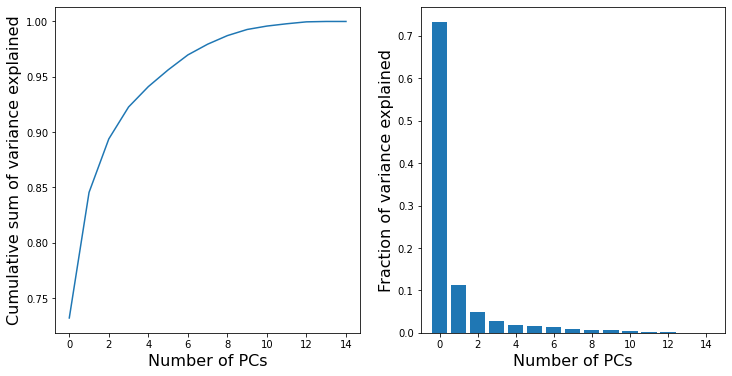

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_).shape)
ax1.set_xlabel("Number of PCs", fontsize=16)
ax1.set_ylabel("Cumulative sum of variance explained", fontsize=16)
ax2.bar(np.arange(15), pca.explained_variance_ratio_)
ax2.axis(xmin=-1,xmax=15)
ax2.set_xlabel("Number of PCs", fontsize=16)
ax2.set_ylabel("Fraction of variance explained", fontsize=16)

Taking the __2 first PC__ may be enough. Each PC consists in a linear combination of variables (here we consider 15 of them). The linear combination weights will be used to compute the future hand-made score of toxicity. We also keep two components to make it simpler (and we don't even know what's the meaning of a combination of weights from the two first principal components).

In [ ]:
cumul = np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumul)):
    print(i+1,'components :', cumul[i])

1 components : 0.7321056094786471
2 components : 0.8455735053558442
3 components : 0.8938916772835757
4 components : 0.9227288841807153
5 components : 0.9411391861729889
6 components : 0.9562306758471425
7 components : 0.9697764692066453
8 components : 0.9794643737208109
9 components : 0.9872222242001183
10 components : 0.9927619250830585
11 components : 0.9958481207733786
12 components : 0.9979225383767207
13 components : 0.9996523100541308
14 components : 0.9999999999999998
15 components : 0.9999999999999998


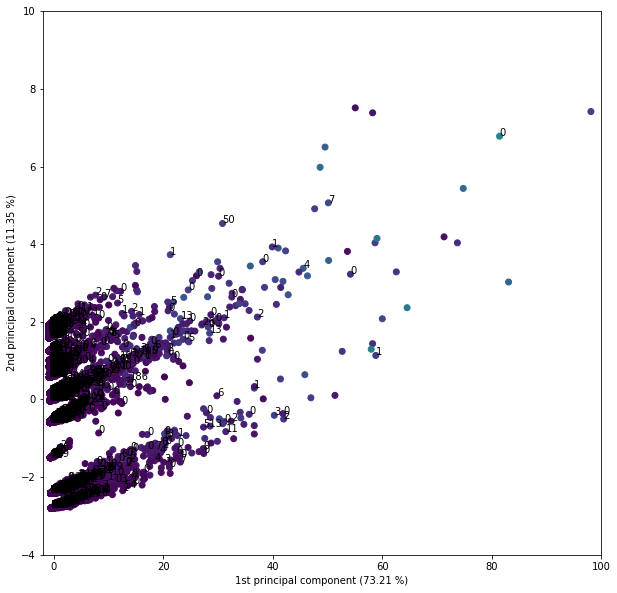

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X_proj[:,0], X_proj[:,1], c=x_train['nbrMotInsulte'])
plt.xlabel('1st principal component (' + str(round(pca.explained_variance_ratio_[0]*100,2))+ ' %)')
plt.ylabel('2nd principal component (' + str(round(pca.explained_variance_ratio_[1]*100,2))+ ' %)')
plt.xlim(-2, 100)
plt.ylim(-4, 10)

for i in range(10000):
    plt.text(X_proj[i,0], X_proj[i,1], df_reduc['nbrMotInsulte'][i])

Text(0, 0.5, '2nd principal component')

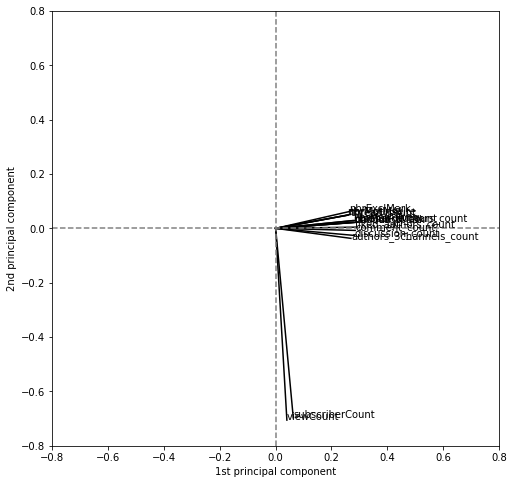

In [ ]:
components = pca.components_
fig = plt.figure(figsize=(8, 8))
for i, (x, y) in enumerate(zip(components[0,:], components[1,:])):
    plt.plot([0, x], [0, y], color='k')
    plt.text(x, y, x_train.columns[i])

plt.plot([-0.8, 0.8], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-0.8, 0.8], color='grey', ls='--')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')

- The __first component__ seems to be correlated with all the variables related to the video comments (number of words, insults, top commments etc.)
- The __second component__ is correlated with the variables showing the popularity of the channel and so the media on Youtube (number of subscribers and views).

Text(0, 0.5, '3rd principal component')

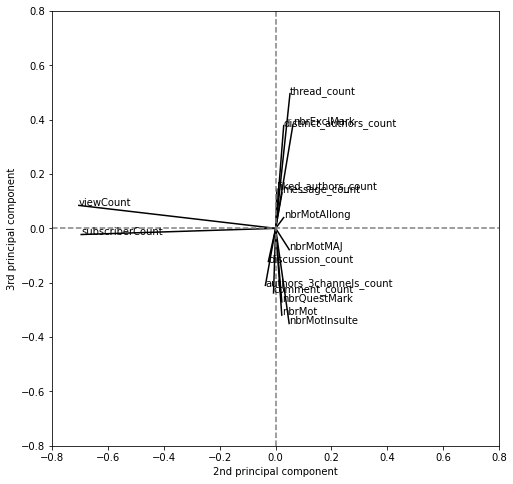

In [ ]:
components = pca.components_
fig = plt.figure(figsize=(8, 8))
for i, (x, y) in enumerate(zip(components[1,:], components[2,:])):
    plt.plot([0, x], [0, y], color='k')
    plt.text(x, y, x_train.columns[i])

plt.plot([-0.8, 0.8], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-0.8, 0.8], color='grey', ls='--')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

plt.xlabel('2nd principal component')
plt.ylabel('3rd principal component')

__Remark__ : it is defficult to see any meaning for the third components.

In [ ]:
PC1_proj = X_proj[:,0]
PC2_proj = X_proj[:,1]

col_pc1 = pd.Series(PC1_proj, name = 'PC_proj', index = x_train.index)
col_pc2 = pd.Series(PC2_proj, name = 'PC_proj', index = x_train.index)

# This is the new hand-made feature
col_mix = col_pc1 - col_pc2

# We transform the previous feature into a score with : 0 (not toxic), 1 (toxic), 2 (very toxic)
qn = np.quantile(col_mix, [0.7,0.9])
qn_split_1 = qn[0]
qn_split_2 = qn[1]

df_final_train = pd.concat([x_train, col_mix], axis=1,ignore_index=False)

df_final_train.loc[df_final_train['PC_proj'] <= qn_split_2, 'Score'] = 1
df_final_train.loc[df_final_train['PC_proj'] > qn_split_2, 'Score'] = 2
df_final_train.loc[df_final_train['PC_proj'] <= qn_split_1, 'Score'] = 0

df_final_train = df_final_train.drop('PC_proj', axis=1)

In [ ]:
df_final_train['Score'].value_counts()

0.0    25807
1.0     7373
2.0     3687
Name: Score, dtype: int64

We compute the true score value on the test set. We will use it to assess a classifier.

In [ ]:
X_test = x_test.values
std_test = StandardScaler().fit(X_test)
X_test_scaled = std_test.transform(X_test)

X_test_proj = pca.transform(X_test_scaled)


col_pc1_test = pd.Series(X_test_proj[:,0], name = 'PC_proj', index = x_test.index)
col_pc2_test = pd.Series(X_test_proj[:,1], name = 'PC_proj', index = x_test.index)

col_mix = col_pc1_test - col_pc2_test

df_final_test = pd.concat([x_test, col_mix], axis=1)

df_final_test.loc[df_final_test['PC_proj'] <= qn_split_2, 'Score'] = 1
df_final_test.loc[df_final_test['PC_proj'] > qn_split_2, 'Score'] = 2
df_final_test.loc[df_final_test['PC_proj'] <= qn_split_1, 'Score'] = 0

df_final_test = df_final_test.drop('PC_proj', axis=1)

df_final_test['Score'].value_counts()

0.0    4746
1.0    3569
2.0     902
Name: Score, dtype: int64

As the new toxicity score is the target, we drop it and prepare the sets for the classifier training.

In [ ]:
y_test_new = df_final_test['Score'].astype(np.int64)
x_test_new = StandardScaler().fit_transform(df_final_test.drop('Score', axis=1))

y_train_new = df_final_train['Score'].astype(np.int64)
x_train_new = StandardScaler().fit_transform(df_final_train.drop('Score', axis=1))

### Model training on the new score

We try a simple Logistic regression classifier and a more complex MLP to evaluate to predict this new score.

In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='saga', multi_class='auto', max_iter=5000).fit(x_train_new, y_train_new)
preds = logit.predict(x_test_new)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

print(confusion_matrix(preds,y_test_new))

print(f1_score(preds,y_test_new,average=None))

[[4735  454    0]
 [  11 3110   32]
 [   0    5  870]]
[0.95319577 0.92531985 0.97917839]


<hr>

## Toxicity index based on correlation coefficients

Firstly, we print the correlation matrix in order to analyse the correlation between 'nbrMotInsulte' and the other features

In [ ]:
import seaborn as sn
Set_correlation2 = pd.concat([X_train,Y_Train], axis=1)
corrMatrix = Set_correlation2.corr()
sn.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (15,4)
plt.show()

NameError: ignored

Following this idea, for each row, we create an index based on the correlation coefficients

In [ ]:
Keys=[]
for key in corrMatrix['nbrMotInsulte'].keys():
    if corrMatrix['nbrMotInsulte'][key]>=0 and key!='nbrMotInsulte':
        Keys.append(key)
print("We will use this features to compute the toxicity index :",Keys)

Indices_Train=[]
for k,row in X_train.iterrows():
    indice=0
    for key in Keys:
        indice+=corrMatrix['nbrMotInsulte'][key]*row[key]
    Indices_Train.append(indice)

Indices_Test=[]
for k,row in X_test.iterrows():
    indice=0
    for key in Keys:
        indice+=corrMatrix['nbrMotInsulte'][key]*row[key]
    Indices_Test.append(indice)

NameError: ignored

In [ ]:
Toxic=[30,50]
Index_Tox=[[] for k in range(len(Toxic)+1)]
Color=[]
for k in range(len(Indices_Test)):
    if Indices_Test[k]<Toxic[0]:
        Index_Tox[0].append(k)
        Color.append(0)
    elif Indices_Test[k]<Toxic[1]:
        Index_Tox[1].append(k)
        Color.append(1)
    else :
        Index_Tox[2].append(k)
        Color.append(2)

To better understand the relevance of our index, we plot in on 2D graph. The videos categorized as a 2/2 about toxicity are the one with the largest number of insult words and the largest number of words. The index seems to illustrate well the reality

In [ ]:
colormap = np.array(['green','orange', 'red'])
plt.scatter(Y_test,X_test['nbrMot'],c=colormap[Color])
#plt.xlim(0,200)
plt.rcParams["figure.figsize"] = (10,10)

Now, we are going to see how the logistic regression can predict this 3-level index and how relevant it is to use this kind of prediction

In [ ]:
def Classifier(Indices):
    tab=np.array(Indices)
    A=[]
    A.append(np.quantile(tab,0.95))
    A.append(np.quantile(tab,0.99))
    Classe=[]
    print(A)
    for p in Indices:
        for q in range(len(A)):
            if p<A[q]:
                Classe.append(q)
                break
        if p>=A[q]:
            Classe.append(q+1)
    Cla=pd.DataFrame(Classe)
    return Cla

We define the 2 borders between the 3 classes. We use the quantiles to do that. 1st quantile is at 95% and the second one is at 99%.

In [ ]:
Cla=Classifier(Indices_Train)
Cla2=Classifier(Indices_Test)

Then we train the model on the "Train set"

In [ ]:
modele_logit = LogisticRegression(solver='saga', multi_class='auto', max_iter=5000)

Cla=Cla.squeeze()
modele_logit.fit(X_train,Cla)

In [ ]:
Cla2_predict=modele_logit.predict(X_test)

In [ ]:
for k in range(3):
    print(list(Cla2_predict).count(k))
plt.scatter(Y_test, Cla2_predict)
#plt.xlim(0,200)
plt.rcParams["figure.figsize"] = (10,5)

The observation is still the same that we done for the calculated index. Thus, we need to compare both of them in order to understand to what extend some videos where badly classified

After doing the prediction of the 3 classes, we evaluate the difference between predicition and the calculated index

In [ ]:
Difference=[]
Cla2_list=Cla2.values.tolist()
for k in range(len(Cla2)):
    Difference.append(Cla2_predict[k]-Cla2_list[k])

In [ ]:
print(Difference.count(1))
print(Difference.count(-1))
plt.scatter(Y_test, Difference)
#plt.xlim(0,200)
plt.rcParams["figure.figsize"] = (10,10)

Only 2 videos were classified as more toxic than what it seems. And 24 were classified as less toxic than the reality, based on our toxicity index.

In [ ]:
confusion_matrix(Cla2_list,Cla2_predict)

By printing the confusion matrix, we better undestand the phenomenon. The accuracy seems good even if some few videos are under-evaluated in regard to calculated toxicity index.

In [ ]:
f1_score(Cla2_list,Cla2_predict, average=None)

Indeed, the accuracy for each of the class is widely acceptable. Our model can be considered as a good one to predict wheter a video is toxic based on three level Low/Medium/High